In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import gc
from train import train
from abstract_image_discriminator import AbstractImageDiscriminator
from input_transformer import InputTransformer
from pytorch_pretrained_biggan import BigGAN, one_hot_from_names
from input_noise_dataset import NoiseDataset

In [61]:
device = torch.device("cuda")

torch.set_printoptions(sci_mode=False)

In [47]:
torch.cuda.empty_cache()
model = InputTransformer().to(device)
torch.cuda.empty_cache()
print("Number of parameters:", model.getNumberOfParameters())

Number of parameters: 566128


In [5]:
dataset = NoiseDataset()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [6]:
biggan = BigGAN.from_pretrained('biggan-deep-512').to(device)
torch.cuda.empty_cache()

In [7]:
discriminator = torch.load("trained_models/abstract_image_discriminator.pkl").to(device)
torch.cuda.empty_cache()

In [8]:
def loss(prediction, label):
    generatedImage = biggan(prediction[0], prediction[1], 0.99)
    isAbstract = discriminator(generatedImage)
    del generatedImage
    gc.collect()
    torch.cuda.empty_cache()
    return torch.sum(1-isAbstract)

In [29]:
model = train(model, optimizer, loss, dataset, device, epochs=1, batchSize=1, countAccuracy=False)

Epoch 1/1
----------

Progress: 100%

Loss: 0.0302 Accuracy: 0.0000 Duration: 18m 29s



In [30]:
torch.save(model, 'trained_models/input_transformer.pkl')

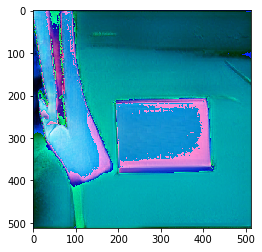

In [81]:
initialInput = dataset[0][0].to(device)
transformedInput = model(initialInput)
generatedImage = biggan(transformedInput[0], transformedInput[1], 0.99)
pilImage = torchvision.transforms.ToPILImage()(torch.squeeze(generatedImage.cpu(), dim=0))
del generatedImage
gc.collect()
torch.cuda.empty_cache()
plt.imshow(pilImage)
plt.show()